# Descripción de las Tablas y Columnas

## **1. MONGO01_Bioquimicos**
- **paciente_id**: Identificador único del paciente.
- **glucosa, colesterol, trigliceridos**: Niveles bioquímicos en sangre.
- **hemoglobina, leucocitos, plaquetas, creatinina**: Indicadores de salud sanguínea.

## **2. MONGO02_Clinicos**
- **paciente_id**: Identificador único del paciente.
- **diabetes, hipertension, obesidad, cancer**: Enfermedades crónicas.
- **enfermedad_cardiaca, asma, epoc**: Condiciones clínicas específicas.

## **3. MONGO03_Geneticos**
- **paciente_id**: Identificador único del paciente.
- **mut_BRCA1, mut_TP53, mut_EGFR, mut_KRAS**: Mutaciones genéticas relevantes.
- **mut_PIK3CA, mut_ALK, mut_BRAF**: Mutaciones adicionales.

## **4. MONGO04_Economicos**
- **paciente_id**: Identificador único del paciente.
- **ingresos_mensuales, gastos_salud**: Información financiera.
- **seguro_salud, deudas, tipo_empleo, ayudas_publicas**: Datos socioeconómicos.

## **5. MONGO05_Generales**
- **paciente_id**: Identificador único del paciente.
- **fumador, alcohol, actividad_fisica, vive**: Hábitos y estilo de vida.

## **6. MONGO06_Sociodemograficos**
- **paciente_id**: Identificador único del paciente.
- **edad, sexo, estado_civil**: Datos personales.
- **nivel_educativo, ocupacion, region, pais_nacimiento, codigo_postal**: Información demográfica.

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [58]:

pd.set_option('display.max_columns', None)  # Mostrar todas las columnas en la salida
# Ruta del archivo
ruta_archivo = r"..\csv\raw\Csv_Todas_Columnas.csv"

# Cargar el archivo CSV en un DataFrame
df = pd.read_csv(ruta_archivo, decimal=',', index_col=0) 

# Mostrar las primeras filas para comprobar
df.head()


,glucosa,colesterol,trigliceridos,hemoglobina,leucocitos,plaquetas,creatinina,diabetes,hipertension,obesidad,cancer,enfermedad_cardiaca,asma,epoc,mut_BRCA1,mut_TP53,mut_EGFR,mut_KRAS,mut_PIK3CA,mut_ALK,mut_BRAF,ingresos_mensuales,gastos_salud,seguro_salud,deudas,tipo_empleo,ayudas_publicas,fumador,alcohol,actividad_fisica,vive,edad,sexo,estado_civil,nivel_educativo,ocupacion,region,pais_nacimiento,codigo_postal
paciente_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
P1000000,108.81,226.16,161.07,13.24,6.12,258.09,0.97,1,1,1,0,1,0,0,0,0,0,0,0,0,1,2699.72,450,1,0,Público,1,1,1,Baja,1,69,F,Viudo,Secundaria,Empleado,Centro,Indonesia,98471
P1000001,74.23,148.89,110.77,13.68,6.97,278.32,0.85,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3403.55,150,1,0,Temporal,1,0,1,Moderada,0,32,M,Soltero,Universitaria,Autónomo,Sur,Brazil,23903
P1000002,88.61,177.53,91.93,12.76,7.54,245.35,1.59,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2422.41,150,1,0,Desempleado,1,1,1,Baja,1,89,M,Viudo,Primaria,Desempleado,Norte,Saint Pierre and Miquelon,20094
P1000003,90.92,203.97,121.79,12.95,8.56,245.11,1.26,1,0,1,1,1,0,0,0,0,0,1,0,0,0,1695.42,450,1,0,Temporal,1,1,1,Baja,0,78,M,Viudo,Secundaria,Autónomo,Centro,Indonesia,55575
P1000004,69.17,154.33,78.34,12.34,8.20,234.44,0.88,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1709.51,150,1,0,Temporal,1,1,1,Moderada,1,38,F,Soltero,Posgrado,Autónomo,Norte,Chile,20826


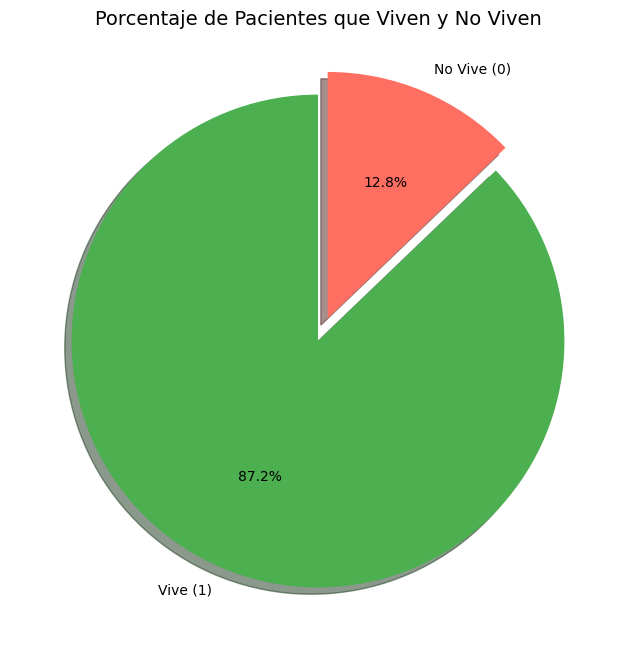

In [50]:
# Calcular los porcentajes de vive (0 y 1)
porcentajes_vive = df['vive'].value_counts(normalize=True) * 100

# Colores personalizados más suaves
colores_bonitos = ['#4CAF50', '#FF6F61']  # Verde y rojo suave

# Crear gráfico de pastel
plt.figure(figsize=(8, 8))
plt.pie(
    porcentajes_vive,
    labels=['Vive (1)', 'No Vive (0)'],
    autopct='%1.1f%%',
    startangle=90,
    colors=colores_bonitos,
    explode=(0, 0.1),  # Resaltar "No Vive"
    shadow=True
)
plt.title('Porcentaje de Pacientes que Viven y No Viven', fontsize=14)
plt.show()


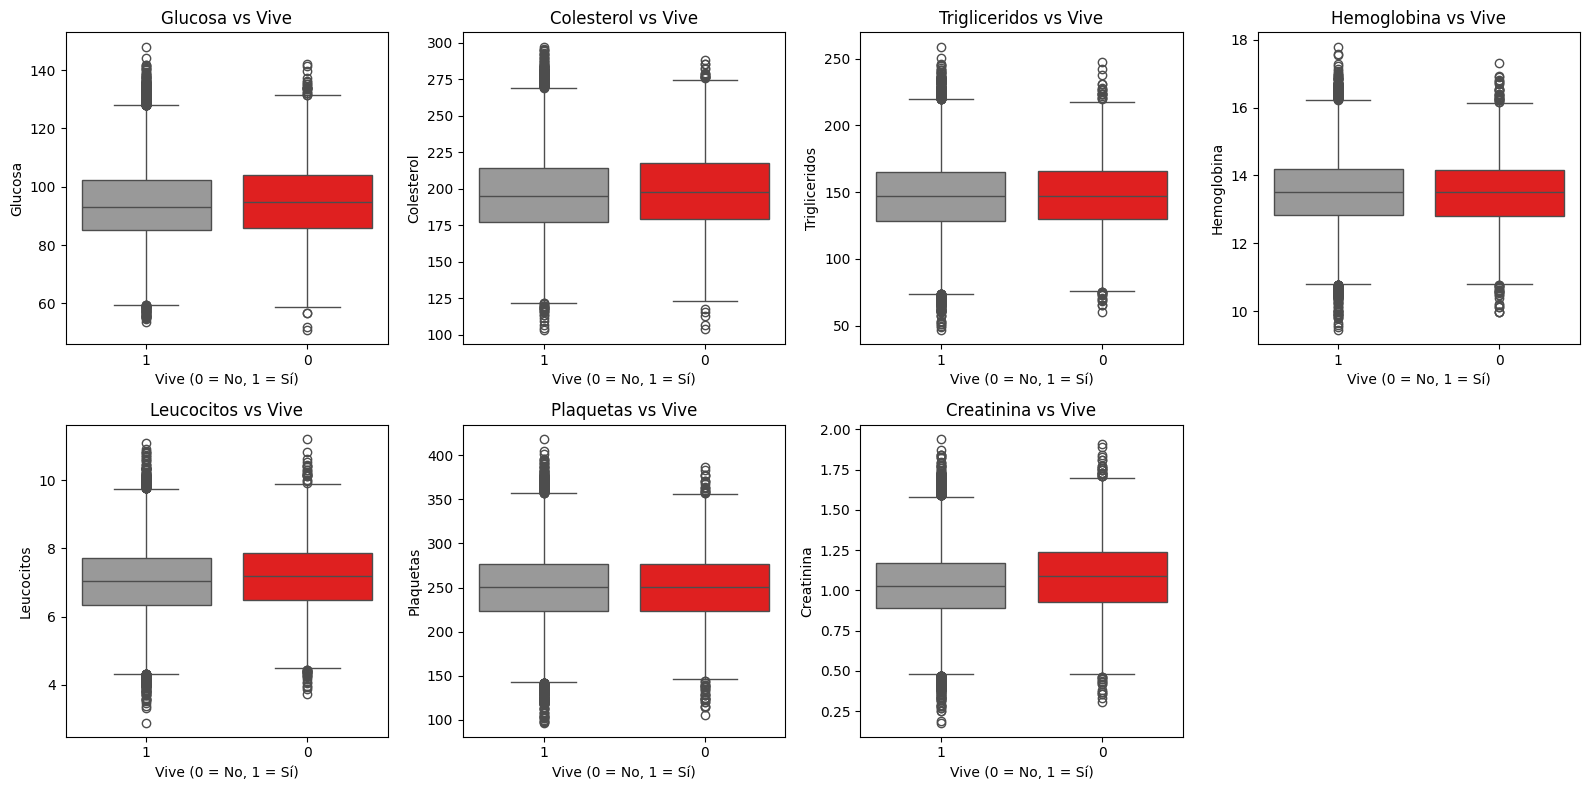

In [51]:
# Lista de variables a graficar
variables = ['glucosa', 'colesterol', 'trigliceridos', 'hemoglobina',
             'leucocitos', 'plaquetas', 'creatinina']


# Convertir 'vive' a string (si no lo está)
df['vive'] = df['vive'].astype(str)

# Definir colores con claves string
colores = {'0': (1, 0, 0, 0.4), '1': (0.6, 0.6, 0.6, 0.4)}

# Crear subplots
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
axes = axes.flatten()

# Crear los boxplots usando hue para evitar warnings
for i, var in enumerate(variables):
    sns.boxplot(x='vive', y=var, hue='vive', data=df, ax=axes[i], palette=colores, legend=False)
    axes[i].set_title(f'{var.capitalize()} vs Vive')
    axes[i].set_xlabel('Vive (0 = No, 1 = Sí)')
    axes[i].set_ylabel(var.capitalize())

# Eliminar subplot extra
if len(variables) < len(axes):
    for j in range(len(variables), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


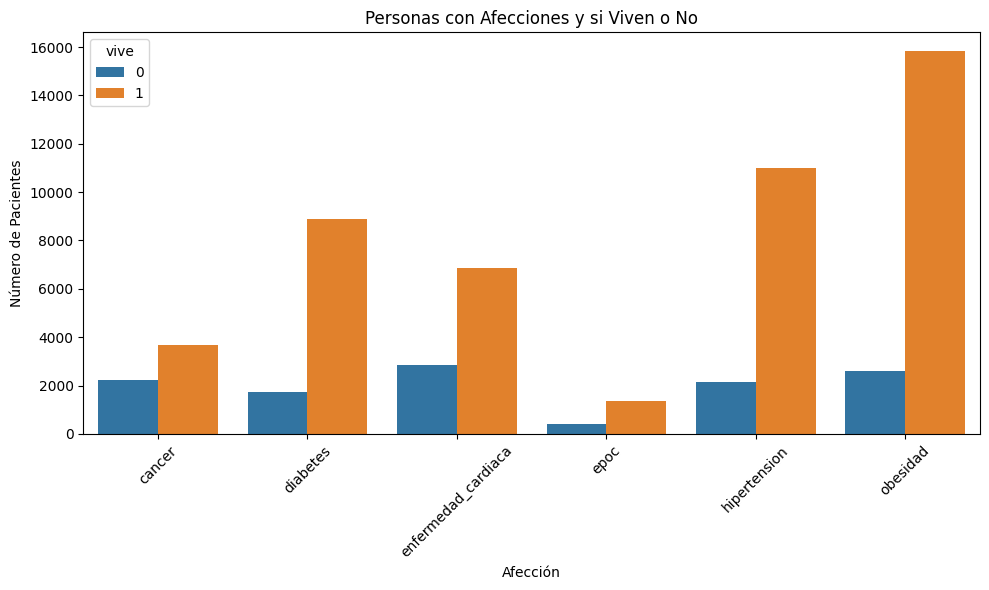

In [52]:
# Lista de afecciones
afecciones = ['diabetes', 'hipertension', 'obesidad', 'cancer',
              'enfermedad_cardiaca', 'asma', 'epoc']

# Convertir 'vive' a string para consistencia visual
df['vive'] = df['vive'].astype(str)

# Derretimos el DataFrame para tener una fila por paciente-afección
df_melt = df.melt(id_vars='vive', value_vars=afecciones,
                  var_name='afeccion', value_name='presencia')

# Filtrar solo los que tienen la afección (presencia = 1)
df_presente = df_melt[df_melt['presencia'] == 1]

# Conteo por afección y vive
conteo = df_presente.groupby(['afeccion', 'vive']).size().reset_index(name='conteo')

# Gráfico de barras apiladas
plt.figure(figsize=(10, 6))
sns.barplot(x='afeccion', y='conteo', hue='vive', data=conteo)
plt.title('Personas con Afecciones y si Viven o No')
plt.ylabel('Número de Pacientes')
plt.xlabel('Afección')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


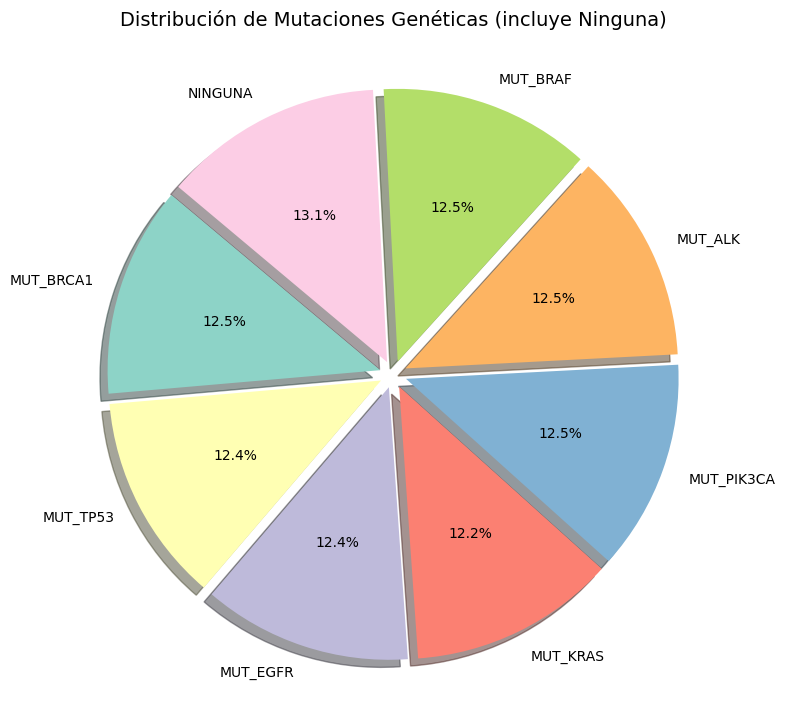

In [53]:
# Simular las columnas de mutaciones si no están disponibles
mutaciones = ['mut_brca1', 'mut_tp53', 'mut_egfr', 'mut_kras', 'mut_pik3ca', 'mut_alk', 'mut_braf']

# Agregar columnas ficticias con valores aleatorios (0 o 1) para demostración
for mut in mutaciones:
    df[mut] = np.random.choice([0, 1], size=len(df), p=[0.8, 0.2])  # 20% probabilidad de tener mutación

# Calcular cuántos pacientes no tienen ninguna mutación
df['ninguna_mutacion'] = (df[mutaciones].sum(axis=1) == 0).astype(int)

# Contar cada tipo de mutación + los que no tienen ninguna
conteo_total = df[mutaciones].sum()
conteo_total['NINGUNA'] = df['ninguna_mutacion'].sum()

# Crear gráfico de pastel
plt.figure(figsize=(8, 8))
plt.pie(
    conteo_total,
    labels=conteo_total.index.str.upper(),
    autopct='%1.1f%%',
    startangle=140,
    colors=plt.cm.Set3.colors,
    explode=[0.05] * len(conteo_total),
    shadow=True
)
plt.title('Distribución de Mutaciones Genéticas (incluye Ninguna)', fontsize=14)
plt.tight_layout()
plt.show()


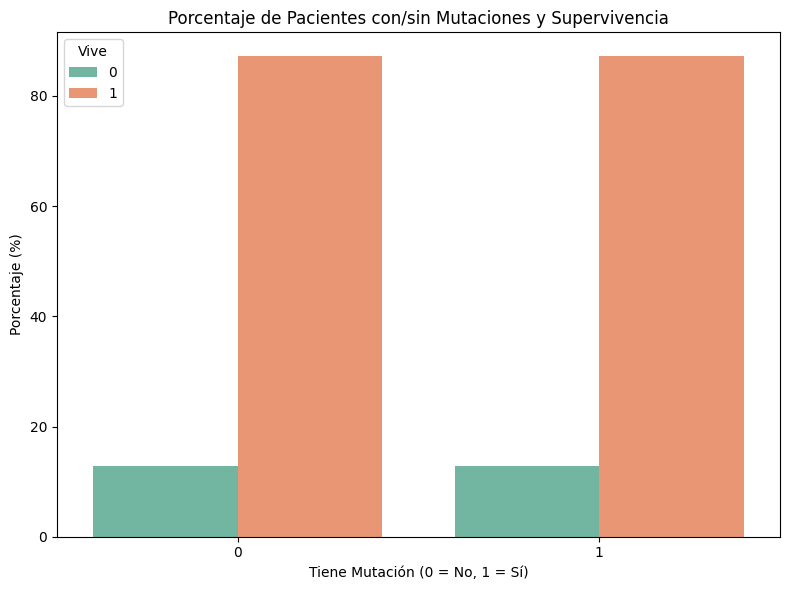

In [54]:
# Crear columna 'tiene_mutacion' si no existe
mutaciones = ['mut_BRCA1', 'mut_TP53', 'mut_EGFR', 'mut_KRAS', 'mut_PIK3CA', 'mut_ALK', 'mut_BRAF']
df['tiene_mutacion'] = df[mutaciones].any(axis=1).astype(int)

# Calcular porcentajes por grupo
conteo = df.groupby(['tiene_mutacion', 'vive']).size().reset_index(name='cuenta')
totales = df.groupby('tiene_mutacion').size().reset_index(name='total')
porcentajes = pd.merge(conteo, totales, on='tiene_mutacion')
porcentajes['porcentaje'] = porcentajes['cuenta'] / porcentajes['total'] * 100

# Gráfico
plt.figure(figsize=(8, 6))
sns.barplot(data=porcentajes, x='tiene_mutacion', y='porcentaje', hue='vive', palette='Set2')
plt.title('Porcentaje de Pacientes con/sin Mutaciones y Supervivencia')
plt.xlabel('Tiene Mutación (0 = No, 1 = Sí)')
plt.ylabel('Porcentaje (%)')
plt.legend(title='Vive')
plt.tight_layout()
plt.show()


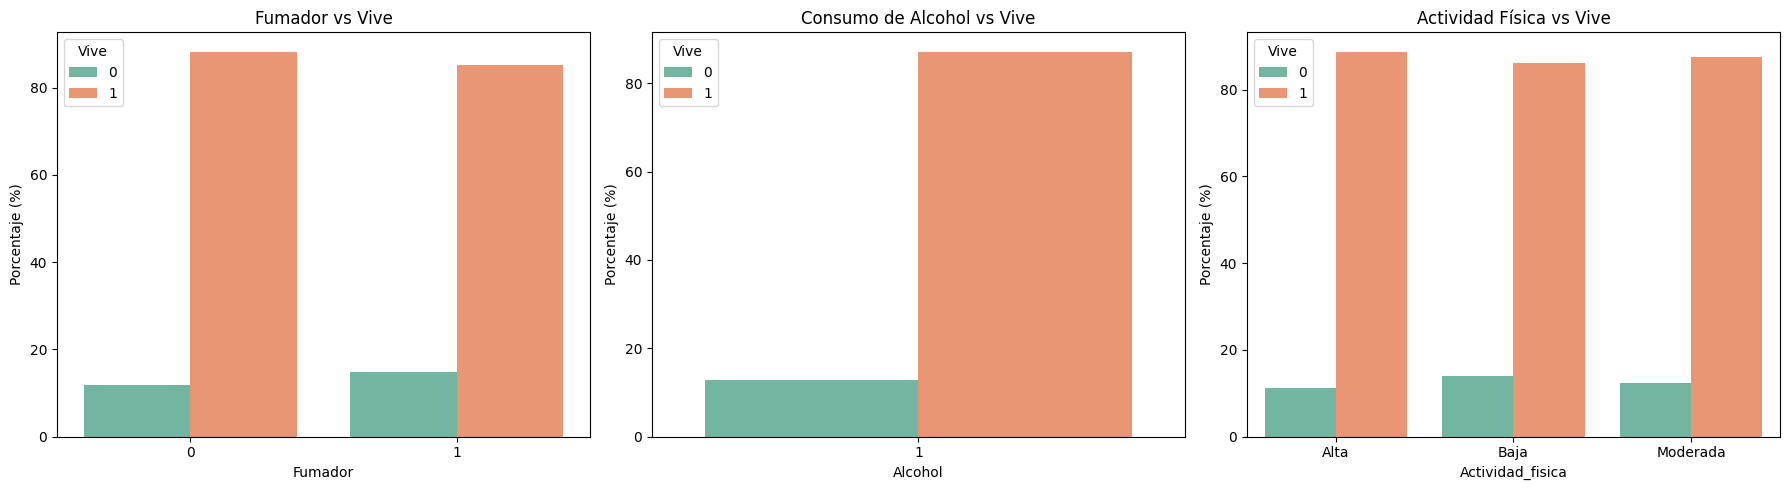

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

habitos = ['fumador', 'alcohol', 'actividad_fisica']
titulos = ['Fumador vs Vive', 'Consumo de Alcohol vs Vive', 'Actividad Física vs Vive']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, habito in enumerate(habitos):
    # Agrupación y cálculo de porcentaje
    conteo = df.groupby([habito, 'vive']).size().unstack(fill_value=0)
    porcentajes = conteo.div(conteo.sum(axis=1), axis=0) * 100
    data = porcentajes.stack().reset_index()
    data.columns = [habito, 'vive', 'porcentaje']

    # Graficar
    sns.barplot(data=data, x=habito, y='porcentaje', hue='vive', ax=axes[i], palette='Set2')
    axes[i].set_title(titulos[i])
    axes[i].set_ylabel('Porcentaje (%)')
    axes[i].set_xlabel(habito.capitalize())
    axes[i].legend(title='Vive')

plt.tight_layout()
plt.show()


C:\Users\josit\AppData\Local\Temp\ipykernel_10840\3325488537.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  conteo = df.groupby(['grupo_edad', 'vive']).size().unstack(fill_value=0)


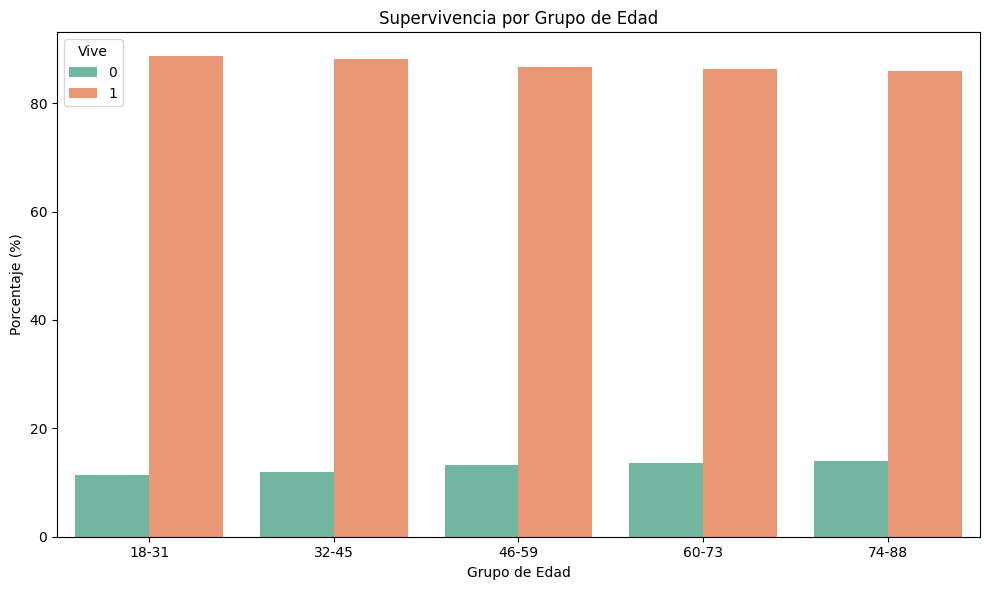

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Obtener edad mínima y máxima y redondear
edad_min = int(np.floor(df['edad'].min()))
edad_max = int(np.ceil(df['edad'].max()))

# Crear 5 intervalos iguales de edad
bins = np.linspace(edad_min, edad_max, 6)  # 5 grupos → 6 bordes
labels = [f"{int(bins[i])}-{int(bins[i+1]-1)}" for i in range(len(bins)-1)]
df['grupo_edad'] = pd.cut(df['edad'], bins=bins, labels=labels, include_lowest=True)

# Calcular porcentajes de supervivencia por grupo de edad
conteo = df.groupby(['grupo_edad', 'vive']).size().unstack(fill_value=0)
porcentajes = conteo.div(conteo.sum(axis=1), axis=0) * 100
data = porcentajes.stack().reset_index()
data.columns = ['grupo_edad', 'vive', 'porcentaje']

# Graficar
plt.figure(figsize=(10, 6))
sns.barplot(data=data, x='grupo_edad', y='porcentaje', hue='vive', palette='Set2')
plt.xlabel('Grupo de Edad')
plt.ylabel('Porcentaje (%)')
plt.title('Supervivencia por Grupo de Edad')
plt.legend(title='Vive')
plt.tight_layout()
plt.show()


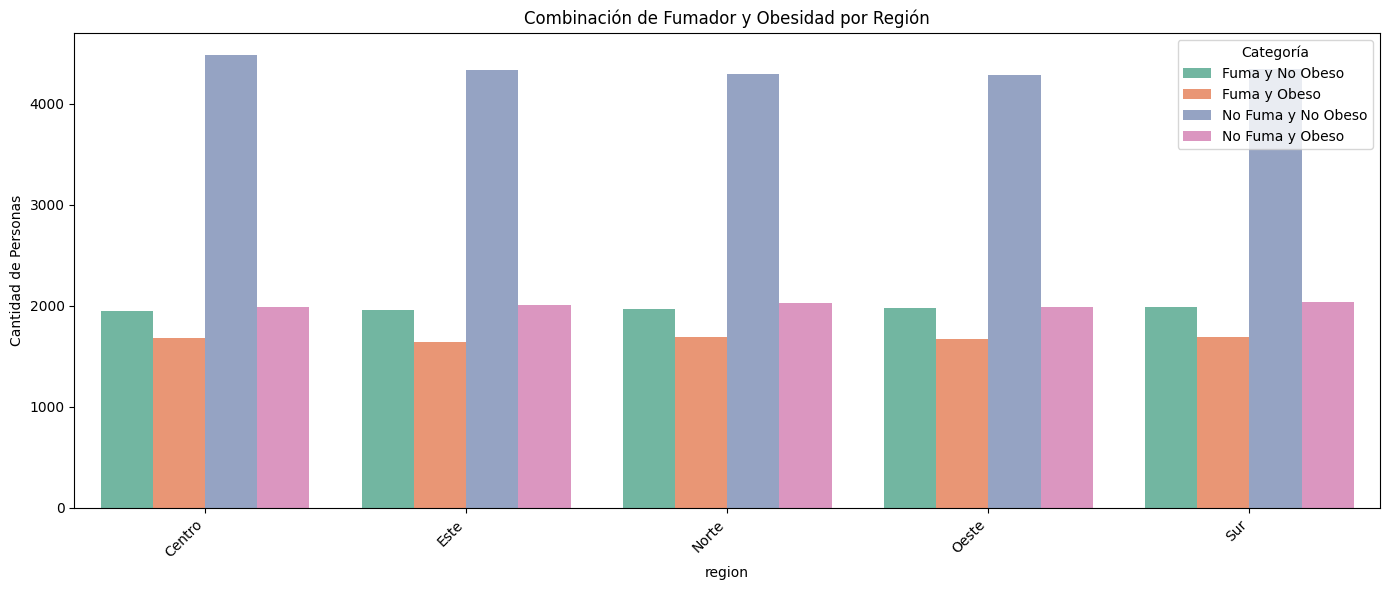

In [57]:
# Crear columna combinada
df['fumador_obeso'] = df.apply(
    lambda row: 
        'Fuma y Obeso' if row['fumador'] == 1 and row['obesidad'] == 1 else
        'Fuma y No Obeso' if row['fumador'] == 1 and row['obesidad'] == 0 else
        'No Fuma y Obeso' if row['fumador'] == 0 and row['obesidad'] == 1 else
        'No Fuma y No Obeso',
    axis=1
)

# Agrupar por región y categoría combinada
conteo = df.groupby(['region', 'fumador_obeso']).size().reset_index(name='cantidad')

# Graficar
plt.figure(figsize=(14, 6))
sns.barplot(data=conteo, x='region', y='cantidad', hue='fumador_obeso', palette='Set2')
plt.title('Combinación de Fumador y Obesidad por Región')
plt.ylabel('Cantidad de Personas')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Categoría')
plt.tight_layout()
plt.show()
